In [4]:
import pickle
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


In [6]:

# Read the pickle object
with open("../../dataset/pickles/LOC3.pickle", "rb") as f:
    data = pickle.load(f)

# Convert the data to a pandas dataframe
df = pd.DataFrame(data)

# Encode the class labels
label_encoder = LabelEncoder()
df['class_label'] = label_encoder.fit_transform(df['class_label'])

# Define the maximum sequence length
max_len = 0
for i in df['lengths']:
    max_len=max(max_len,len(i))

# Pad the sequences to the maximum length
sequences = np.array(df['lengths'])
padded_sequences = np.zeros((len(sequences), max_len))
for i, sequence in enumerate(sequences):
    padded_sequences[i, :len(sequence)] = sequence

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, df['class_label'], test_size=0.2)

# Convert the data to PyTorch tensors
X_train = torch.from_numpy(X_train).to(torch.float32)
y_train = torch.from_numpy(y_train.values).long()
X_val = torch.from_numpy(X_val).to(torch.float32)
y_val = torch.from_numpy(y_val.values).long()
# check if split is stratified
# print("Training set class distribution:")
# print(y_train.unique(return_counts=True)) 
# print("Validation set class distribution:")
# print(y_val.unique(return_counts=True))
print(y_train.unique().shape)
print(y_val.unique().shape)

torch.Size([1500])
torch.Size([1500])


In [7]:
# Define a custom dataset
class SequenceDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        sequence = self.sequences[index]
        label = self.labels[index]
        return sequence, label


In [8]:

# Initialize the model
input_dim=0
for i in X_train:
    input_dim = max(input_dim,len(i))
# input_dim = len(X_train[0])
hidden_dim = 128
output_dim = 1500
learning_rate = 1e-3
print(input_dim)
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
# Define the dataloaders
train_dataset = SequenceDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = SequenceDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


1213


In [9]:
# Define the model architecture
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, batch_size):
        super(RNN, self).__init__()
        self.batch_size=batch_size
        # simple 1d conv 
        self.conv1 = nn.Conv1d(1, 8, 3, padding=1)
        self.bn1 = nn.BatchNorm1d(8)
        self.relu = nn.ReLU()        
        
        # parameters for the RNN
        self.hidden_dim = hidden_dim
        self.input_dim = input_dim
        self.output_dim = output_dim

        # define the RNN
        # self.rnn = nn.LSTM(8*input_dim, hidden_dim, batch_first=True)
        self.rnn = nn.RNN(8*input_dim, hidden_dim, batch_first=True)
        # define the output layer
        self.fc = nn.Linear(hidden_dim, output_dim)    
        self.h = self.init_hidden(self.batch_size)    
        self.flatten = nn.Flatten()
        # self.fc = nn.Linear(8*input_dim, output_dim)
        
    def init_hidden(self, bsz):
        # initialize the hidden state
        self.h=torch.zeros(1, bsz, self.hidden_dim).to(device)
    
    def forward(self, x):
        # reshape the input
        # x = x.view(self.batch_size, self.input_dim, -1)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.flatten(x)
        # initialize the hidden state
        self.init_hidden(x.shape[0])
        # get RNN unit outputs
        out, h = self.rnn(x.unsqueeze(1), self.h)
        # get the output for the last time step
        out = self.fc(out[:, -1, :])
        return out


In [10]:
device = torch.device('cuda:6' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
rnn = RNN(input_dim, hidden_dim, output_dim, batch_size=64)
rnn = rnn.to(device)
criterion = criterion.to(device)

optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)


Using device: cuda:6


In [13]:
from sklearn.metrics import precision_recall_fscore_support
def get_precision_recall_f1(y_true, y_pred):
    """Calculate precision, recall, F1 score for each class.
    Args:
        y_true (list): list of true labels
        y_pred (list): list of predicted labels
    Returns:
        dict: dictionary with precision, recall, F1 score for each class
    """
    # Calculate precision, recall, F1 score for each class
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
    return {
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

num_epochs = 50
# optimizer = optimizer.to(device)
for epoch in range(num_epochs):
    running_loss = 0.0
    running_corrects = 0
    rnn.train()
    for sequences, labels in train_loader:
        optimizer.zero_grad()
        labels = labels.to(device)
        sequences = sequences.to(device)
        sequences = sequences.unsqueeze(1)
        outputs = rnn(sequences)
        
        # print(sequences.shape)
        # print(outputs.shape)
        # print(labels.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * sequences.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels)
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() /len(train_dataset)
    print('Train Loss: {:.4f} Train Acc: {:.4f} %'.format(epoch_loss, epoch_acc*100))
    
    # test the model
    rnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        total_preds = []
        total_labels = []
        for sequences, labels in val_loader:
            sequences = sequences.to(device)
            labels = labels.to(device)
            sequences = sequences.unsqueeze(1)
            outputs = rnn(sequences)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            total_preds.append(predicted)
            total_labels.append(labels)
        
        print('Epoch: {}, Test Accuracy of the model on the test sequences: {} %'.format(epoch, 100 * correct / total))
        total_preds = torch.cat(total_preds, dim=0)
        total_labels = torch.cat(total_labels, dim=0)
        print(get_precision_recall_f1(total_labels.cpu(), total_preds.cpu()))

Train Loss: 4.1880 Train Acc: 20.4928 %
Epoch: 0, Test Accuracy of the model on the test sequences: 38.5645593313325 %
{'precision': 0.40355490708855574, 'recall': 0.3889125439817476, 'f1': 0.3495203446593721}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


KeyboardInterrupt: 

In [62]:
# save model
rnn.load_state_dict(torch.load('rnn_model_main.ckpt'))
# torch.save(rnn.state_dict(), 'rnn_model_main.ckpt')


<All keys matched successfully>

In [63]:
# Evaluate the model
running_loss = 0.0
running_corrects = 0
rnn.eval()
with torch.no_grad():
    for sequences, labels in val_loader:
        labels = labels.to(device)
        sequences = sequences.to(device)
        sequences = sequences.unsqueeze(1)
        outputs = rnn(sequences)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * sequences.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels)
epoch_loss = running_loss / len(val_dataset)
epoch_acc = running_corrects.double() / len(val_dataset)
print('Val Loss: {:.4f} Val Acc: {:.4f}'.format(epoch_loss, epoch_acc))


Val Loss: 0.3739 Val Acc: 0.8932


In [64]:
# from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, EigenGradCAM
# import matplotlib.pyplot as plt 
# torch.backends.cudnn.enabled=False

# x,y = next(iter(val_loader))
# ls=[]
# for l in rnn.children():
#     ls+=[l]
# # ls=ls[:3]
# # ls
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# rnn.train()
# cam = GradCAM(model=rnn, target_layers=[ls[-1]], use_cuda=True)
# # cam = cam.to(device)
# # [1, 64, 1213]
# x = x.unsqueeze(1).to(device)

# print(x.shape)
# # x = torch.permute(x,(1,0,2))
# # print(rnn)
# # print(x)
# # x=x[0]
# x_cam = cam(input_tensor=x)
# # viusalize the CAM result
# plt.imshow(x_cam[0, :], cmap='jet')
# plt.show()

In [65]:
# from omnixai.explainers.vision.specific.gradcam.pytorch.gradcam import GradCAM
# from omnixai.explainers.vision.specific.gradcam.pytorch.gradcam import GradCAM
# x,y = next(iter(val_loader))
# x = x.unsqueeze(1).to(device)
# ls=[]
# for l in rnn.children():
#     ls+=[l]
# # ls=ls[:3]
# # ls
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# rnn.train()
# explainer = GradCAM(model=rnn, target_layer=ls[0],preprocess_function=lambda x:x)
# explanations = explainer.explain(x.to(device))
# explanations.ipython_plot(index=0, class_names=y)


In [66]:
# def grad_cam(input_model, data, category_index, layer_name, nb_classes):
#     def target_layer(x): return target_category_loss(
#         x, category_index, nb_classes)
#     x = input_model.children()[-1].output
#     x = Lambda(target_layer, output_shape=target_category_loss_output_shape)(x)
#     model = Model(input_model.layers[0].input, x)
#     loss = K.sum(model.layers[-1].output)
#     conv_output = [l for l in model.layers if l.name is layer_name][0].output

#     grads = normalize(K.gradients(loss, conv_output)[0])
#     gradient_function = K.function(
#         [model.layers[0].input], [conv_output, grads])
#     output, grads_val = gradient_function([data])
#     output, grads_val = output[0, :], grads_val[0, :, :]
#     weights = np.mean(grads_val, axis=(0))
#     # cam = np.ones(output.shape[0: 1], dtype=np.float32)
#     # for i, w in enumerate(weights):
#     #     cam += w * output[:, i]
#     cam = output.dot(weights)
#     # print(cam)
#     cam = resize_1d(cam, (data.shape[1]))
#     cam = np.maximum(cam, 0)
#     # heatmap = cam / np.max(cam)
#     heatmap = (cam - np.min(cam))/(np.max(cam) - np.min(cam)+1e-10)
#     return heatmap

In [67]:


from torch.nn import functional as F
import matplotlib.pyplot as plt
def get_gra_cam_on_1d(model, x, y):
    '''
    given a pytorch model, an input x, and a target y, returns the gradient of 
    the loss with respect to 
    '''
    model.zero_grad()
    x.requires_grad = True
    y_hat = model(x)
    loss = F.cross_entropy(y_hat, y)
    loss.backward()
    return x.grad.data# from grad_cam import grad_cam
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
val_loader2 = torch.utils.data.DataLoader(val_dataset, batch_size=9000, shuffle=True)
x,y=next(iter(val_loader2))
print(x.shape)
rnn = rnn.to(device)
x = x.unsqueeze(1).to(device)
y = y.to(device)

x_grad = get_gra_cam_on_1d(rnn,x,y)
x_grad = np.abs(x_grad)
x_grad = x_grad.squeeze(1)
print(x_grad.shape)

torch.Size([9000, 1213])
torch.Size([9000, 1213])


In [68]:
print(x_grad)

tensor([[1.8417e-10, 1.4440e-09, 6.3000e-10,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [2.6410e-10, 2.0309e-10, 1.0922e-09,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.7904e-12, 1.6734e-11, 1.9734e-13,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [4.5450e-08, 1.4181e-07, 2.7941e-09,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.9676e-06, 9.2775e-06, 3.8486e-06,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.4024e-12, 3.5292e-12, 2.3619e-12,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


In [69]:
print((x_grad.max(dim=1).values-x_grad.min(dim=1).values).unsqueeze(1).expand_as(x_grad).shape)
print(x_grad.shape)


torch.Size([9000, 1213])
torch.Size([9000, 1213])


[[0.03292321 0.25813523 0.11262453 ... 0.         0.         0.        ]
 [0.02098738 0.01613913 0.08679768 ... 0.         0.         0.        ]
 [0.0499141  0.22036693 0.00259866 ... 0.         0.         0.        ]
 ...
 [0.02844823 0.08876019 0.00174892 ... 0.         0.         0.        ]
 [0.2120848  1.         0.41482803 ... 0.         0.         0.        ]
 [0.03967937 0.04115858 0.027545   ... 0.         0.         0.        ]]


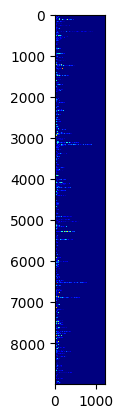

In [70]:
x_grad = x_grad - x_grad.min(dim=1).values.unsqueeze(1).expand_as(x_grad)
x_grad = x_grad.div ((x_grad.max(dim=1).values-x_grad.min(dim=1).values).unsqueeze(1).expand_as(x_grad))

x_grad = x_grad.squeeze(0)
x_grad = x_grad.cpu().numpy()
print(x_grad)

# plot heatmap
plt.imshow(x_grad, cmap='jet', interpolation='nearest')
plt.show()

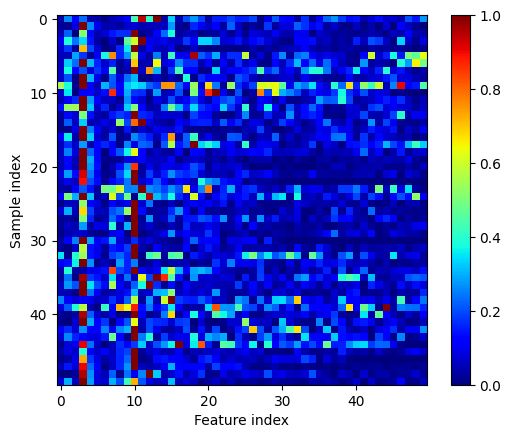

In [75]:
x_grad_clip= x_grad[:50,:50]
plt.imshow(x_grad_clip, cmap='jet', interpolation='nearest')
plt.colorbar()
# plt.title('Contribution of features to the gradient of the output')
plt.xlabel('Feature index')
plt.ylabel('Sample index')
plt.show()


In [72]:
non_zero_count = (x_grad != 0).sum(0)
x_grad_norm_sum = x_grad.sum(0)
x_grad_norm_sum[non_zero_count != 0] /= non_zero_count[non_zero_count != 0]
print(x_grad_norm_sum)

[0.06734419 0.22715989 0.11713807 ... 0.         0.         0.        ]


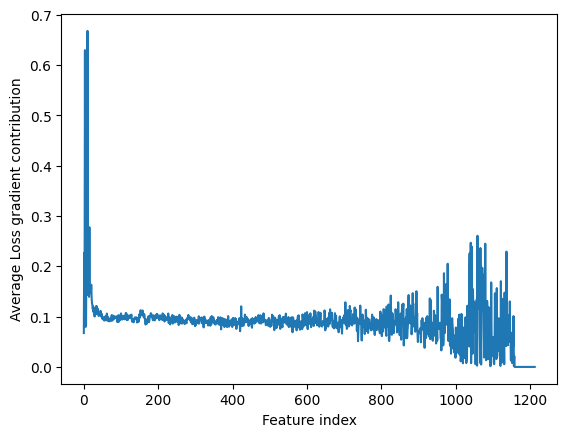

In [73]:
x_grad_avg = x_grad_norm_sum
plt.plot(x_grad_avg)
# plt.title('Average Loss gradient contribution with respect to input')
plt.xlabel('Feature index')
plt.ylabel('Average Loss gradient contribution')
plt.show()

In [74]:
print(np.argsort(x_grad_avg)[::-1][:50])


[  10    3   15    9 1058    7 1040 1079 1043 1066 1136    1 1037 1063
  978 1071   12   13  968 1074 1036    4 1121 1095 1062  974   20  951
   18 1110   17 1046  894 1131   19  884 1072 1105   16    8  962  873
   11 1060  825  972   14   21  930 1126]


In [103]:
x_z = x.squeeze(1)
x_loc = x_z>0
print(x_loc.sum())
print(np.sum(x_grad[x_loc]))
print(torch.numel(x_loc)-x_loc.sum())
print(np.sum(x_grad)-np.sum(x_grad[x_loc]))

pos_contrib = np.sum(np.abs(x_grad[x_loc]))/x_loc.sum()
neg_contrib = (np.sum(np.abs(x_grad))-np.sum(np.abs(x_grad[x_loc])))/(torch.numel(x_loc)-x_loc.sum())

print("Contribution due to outgoing packets: ", pos_contrib/(pos_contrib+neg_contrib))
print("Contribution due to incoming packets: ", neg_contrib/(pos_contrib+neg_contrib))


tensor(616995)
91057.46
tensor(10300005)
37620.734
Contribution due to outgoing packets:  tensor(0.9758)
Contribution due to incoming packets:  tensor(0.0242)
